In [3]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from cybnews.data import get_data
from matplotlib.pylab import plt
import numpy as np


import string
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.metrics import accuracy_score


from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestClassifier

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression



from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM,Bidirectional
from tensorflow.keras.layers import Dense, Dropout


ModuleNotFoundError: No module named 'tensorflow'

In [4]:
# df = get_data('/Users/admin/code/frederiklm/cyb-news/data/WELFake_Dataset.csv')

data = get_data('/Users/admin/code/frederiklm/cyb-news/data/WELFake_Dataset.csv')

In [5]:
#data = pd.read_csv('/Users/admin/code/frederiklm/cyb-news/data/WELFake_Dataset.csv')
data.head()

,Unnamed: 0,title,text,label
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1
1,1,NaN,Did they post their votes for Hillary already?,1
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1


In [6]:
data.shape

(72134, 4)

In [7]:
data.info

<bound method DataFrame.info of        Unnamed: 0                                              title  \
0               0  LAW ENFORCEMENT ON HIGH ALERT Following Threat...   
1               1                                                NaN   
2               2  UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...   
3               3  Bobby Jindal, raised Hindu, uses story of Chri...   
4               4  SATAN 2: Russia unvelis an image of its terrif...   
...           ...                                                ...   
72129       72129  Russians steal research on Trump in hack of U....   
72130       72130   WATCH: Giuliani Demands That Democrats Apolog...   
72131       72131  Migrants Refuse To Leave Train At Refugee Camp...   
72132       72132  Trump tussle gives unpopular Mexican leader mu...   
72133       72133  Goldman Sachs Endorses Hillary Clinton For Pre...   

                                                    text  label  
0      No comment is expected from Ba

In [8]:
data.describe()

,Unnamed: 0,label
count,72134.000000,72134.000000
mean,36066.500000,0.514404
std,20823.436496,0.499796
min,0.000000,0.000000
25%,18033.250000,0.000000
50%,36066.500000,1.000000
75%,54099.750000,1.000000
max,72133.000000,1.000000


In [9]:
data.label.value_counts(normalize=True)

label
1    0.514404
0    0.485596
Name: proportion, dtype: float64

In [10]:
duplicateRows = data[data.duplicated()]

In [11]:
duplicateRows.shape

(0, 4)

In [12]:
data.isnull().any()

Unnamed: 0    False
title          True
text           True
label         False
dtype: bool

In [13]:
data.isnull().sum()

Unnamed: 0      0
title         558
text           39
label           0
dtype: int64

In [14]:
data = data.fillna('')

In [15]:
data["all_text"] = data["title"] + " " +  data["text"]

In [16]:
data['text_length'] = data['all_text'].apply(len)
data.head()

,Unnamed: 0,title,text,label,all_text,text_length
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,5180
1,1,,Did they post their votes for Hillary already?,1,Did they post their votes for Hillary already?,47
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,354
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"Bobby Jindal, raised Hindu, uses story of Chri...",8116
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,SATAN 2: Russia unvelis an image of its terrif...,2012


In [17]:
data.groupby('label')['text_length'].mean()

label
0    3565.107286
1    3139.031208
Name: text_length, dtype: float64

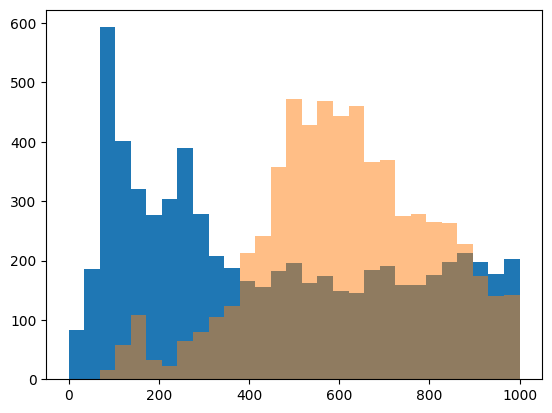

(array([6.358e+03, 5.663e+03, 7.832e+03, 4.112e+03, 3.355e+03, 2.598e+03,
        1.771e+03, 1.331e+03, 7.570e+02, 4.070e+02, 2.120e+02, 1.250e+02,
        7.400e+01, 6.400e+01, 7.100e+01, 3.900e+01, 2.200e+01, 2.800e+01,
        2.100e+01, 2.900e+01, 1.100e+01, 1.700e+01, 8.000e+00, 1.000e+01,
        1.800e+01, 9.000e+00, 1.300e+01, 7.000e+00, 4.000e+00]),
 array([    0.        ,  1034.48275862,  2068.96551724,  3103.44827586,
         4137.93103448,  5172.4137931 ,  6206.89655172,  7241.37931034,
         8275.86206897,  9310.34482759, 10344.82758621, 11379.31034483,
        12413.79310345, 13448.27586207, 14482.75862069, 15517.24137931,
        16551.72413793, 17586.20689655, 18620.68965517, 19655.17241379,
        20689.65517241, 21724.13793103, 22758.62068966, 23793.10344828,
        24827.5862069 , 25862.06896552, 26896.55172414, 27931.03448276,
        28965.51724138, 30000.        ]),
 <BarContainer object of 29 artists>)

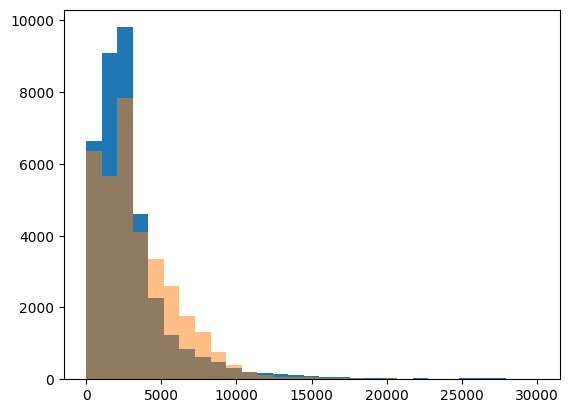

In [18]:


bin = np.linspace(0, 1000, 30)
plt.hist(data[data["label"]== 1]["text_length"], bins=bin)
plt.hist(data[data["label"]== 0]["text_length"], bins=bin, alpha= 0.5)
plt.show();
bin = np.linspace(0, 30000, 30)
plt.hist(data[data["label"]== 1]["text_length"], bins=bin)
plt.hist(data[data["label"]== 0]["text_length"], bins=bin, alpha= 0.5)

In [19]:
# One could argue to only use data["text"] as X


data["all_text"]


data.head()

,Unnamed: 0,title,text,label,all_text,text_length
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,No comment is expected from Barack Obama Membe...,1,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,5180
1,1,,Did they post their votes for Hillary already?,1,Did they post their votes for Hillary already?,47
2,2,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,"Now, most of the demonstrators gathered last ...",1,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,354
3,3,"Bobby Jindal, raised Hindu, uses story of Chri...",A dozen politically active pastors came here f...,0,"Bobby Jindal, raised Hindu, uses story of Chri...",8116
4,4,SATAN 2: Russia unvelis an image of its terrif...,"The RS-28 Sarmat missile, dubbed Satan 2, will...",1,SATAN 2: Russia unvelis an image of its terrif...,2012


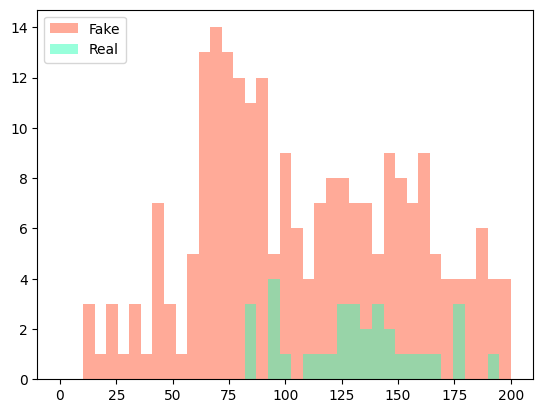

In [39]:
data["body_len"] = data["all_text"].apply(lambda x: len(x) - x.count(" "))

bins = np.linspace(0, 200, 40)

plt.hist(data[data["label"]== 1]["body_len"], bins, alpha=0.5, label="Fake", color="#FF5733")
plt.hist(data[data["label"]== 0]["body_len"], bins, alpha=0.5, label="Real", color="#33FFB8")
plt.legend(loc="upper left")
plt.show()

In [20]:
"""# Formula to count the most used wrds
import string
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from collections import Counter

def word_count(sentence):
    sentence = sentence.strip()
    sentence = sentence.lower()
    sentence = "".join(char for char in sentence if not char.isdigit())
    for x in string.punctuation:
        sentence = sentence.replace(x, "")
    for x in ["’", "“", "”", "-" ]:
        sentence = sentence.replace(x, "")
    tokens = word_tokenize(sentence)
    language = set(stopwords.words("english"))
    sentence = [w for  w in tokens if not w in language]
    language.difference_update(["not", "no","nor", "against", "however", "but", "never", "should", "would" , "could", "might", "must", "no", "yes", "always", "none", "only", "still", "yet", "despite", "unless", "until", "cannot" ])

    sentence = [w for  w in tokens if not w in language]
    v_l = [WordNetLemmatizer().lemmatize(word, pos = "v") for word in sentence]
    n_l = [WordNetLemmatizer().lemmatize(word, pos = "n") for word in v_l]
    word_counts = Counter(n_l)

    return word_counts

total_word_counts = Counter()
data["all_text_cleaned_test"] = data["all_text"].apply(word_count)
for counts in data["all_text_cleaned_test"]:
    total_word_counts.update(counts)
total = sum(total_word_counts.values())

most_common_words = total_word_counts.most_common(100)
for word, count in most_common_words:
    print(f"{word}: {count}")"""


'# Formula to count the most used wrds\nimport string\nfrom nltk.corpus import stopwords\nfrom nltk import word_tokenize\nfrom nltk.stem import WordNetLemmatizer\nfrom collections import Counter\n\ndef word_count(sentence):\n    sentence = sentence.strip()\n    sentence = sentence.lower()\n    sentence = "".join(char for char in sentence if not char.isdigit())\n    for x in string.punctuation:\n        sentence = sentence.replace(x, "")\n    for x in ["’", "“", "”", "-" ]:\n        sentence = sentence.replace(x, "")\n    tokens = word_tokenize(sentence)\n    language = set(stopwords.words("english"))\n    sentence = [w for  w in tokens if not w in language]\n    language.difference_update(["not", "no","nor", "against", "however", "but", "never", "should", "would" , "could", "might", "must", "no", "yes", "always", "none", "only", "still", "yet", "despite", "unless", "until", "cannot" ])\n\n    sentence = [w for  w in tokens if not w in language]\n    v_l = [WordNetLemmatizer().lemmatize

In [21]:
#len(stopwords.words("english"))

#print(stopwords.words("english"))

In [22]:
# Discuss on strategy here -> Stopwords to add and delete | is .lower() smart since FAKES MIGHT BE CAPITAL |


def preprocessing(sentence):
    sentence = sentence.strip()
    sentence = sentence.lower()
    sentence = "".join(char for char in sentence if not char.isdigit())
    for x in string.punctuation:
        sentence = sentence.replace(x, "")

    for x in ["’", "“", "”", "-" ]:
        sentence = sentence.replace(x, "")
    #for x in '""':
        #sentence = sentence.replace(x, "")

    tokens = word_tokenize(sentence)

    language = set(stopwords.words("english"))
    #language.update(["trump", "clinton", "obama"])
    language.difference_update(["not", "no","nor", "against", "however", "but", "never", "should", "would" , "could", "might", "must", "no", "yes", "always", "none", "only", "still", "yet", "despite", "unless", "until", "cannot" ])
    sentence = [w for  w in tokens if not w in language]
    v_l = [WordNetLemmatizer().lemmatize(word, pos = "v") for word in sentence]
    n_l = [WordNetLemmatizer().lemmatize(word, pos = "n") for word in v_l]
    return ' '.join(n_l)

In [23]:
data = data.sample(frac=0.1, random_state=42)

In [24]:
data["all_text_cleaned"] = data["all_text"].apply(preprocessing)

In [25]:
data_ready = data[["all_text_cleaned", "label"]]

In [26]:
data_ready


,all_text_cleaned,label
61370,arnold schwarzenegger send message liberal whi...,1
2189,wow mexican need kill donald trump become pres...,1
60609,jimmy carter recover dehydration scare canada ...,0
51565,friar mission revive brooklyn church religious...,0
39431,boy autism make first friend ever mom cant sto...,1
...,...,...
46006,obama condemn trump…says u bless muslim commun...,1
33197,czech foreign minister lightly injure car acci...,0
61712,house intel slap subpoena mccain institute ass...,1
17836,terror group plan violence against trump suppo...,1


In [27]:
y = data_ready["label"]
X = data_ready["all_text_cleaned"]

In [28]:
X.head()

61370    arnold schwarzenegger send message liberal whi...
2189     wow mexican need kill donald trump become pres...
60609    jimmy carter recover dehydration scare canada ...
51565    friar mission revive brooklyn church religious...
39431    boy autism make first friend ever mom cant sto...
Name: all_text_cleaned, dtype: object

In [29]:
#Split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [30]:
X_train

16886    microsoft find cancer clue search query new yo...
63308    kamala harrisleftist senator california next d...
64617    indonesian parliament speaker name suspect mas...
61031    turkey say recognize jerusalem capital would c...
36853    obamas dream america nightmare illegal alien c...
                               ...                        
52834    candidate run president only one pay intern ni...
68373    virginia judge issue new injunction against tr...
10527    right group urge eu japan consider halt fund c...
27342    choose best battery prepper solar system carme...
34276    spacex rocket explode launchpad cape canaveral...
Name: all_text_cleaned, Length: 5049, dtype: object

In [31]:


pipe = make_pipeline(CountVectorizer(),MultinomialNB())


In [34]:
pipe.get_params()

{'memory': None,
 'steps': [('countvectorizer', CountVectorizer()),
  ('multinomialnb', MultinomialNB())],
 'verbose': False,
 'countvectorizer': CountVectorizer(),
 'multinomialnb': MultinomialNB(),
 'countvectorizer__analyzer': 'word',
 'countvectorizer__binary': False,
 'countvectorizer__decode_error': 'strict',
 'countvectorizer__dtype': numpy.int64,
 'countvectorizer__encoding': 'utf-8',
 'countvectorizer__input': 'content',
 'countvectorizer__lowercase': True,
 'countvectorizer__max_df': 1.0,
 'countvectorizer__max_features': None,
 'countvectorizer__min_df': 1,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__preprocessor': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__strip_accents': None,
 'countvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'countvectorizer__tokenizer': None,
 'countvectorizer__vocabulary': None,
 'multinomialnb__alpha': 1.0,
 'multinomialnb__class_prior': None,
 'multinomialnb__fit_prior': True,
 'multinomialnb__force_alpha': T

In [34]:

grid = {"countvectorizer__ngram_range": ((1,1), (2,1), (1,2), (2,2)),
        "multinomialnb__alpha": (0.01, 0.1, 1)}


search_g = GridSearchCV(pipe,grid, scoring = "accuracy", cv =5, n_jobs=-1)

search_g.fit(X_train,y_train)


search_g.best_score_

KeyboardInterrupt: 

In [216]:
search_g.best_params_


{'countvectorizer__ngram_range': (1, 2), 'multinomialnb__alpha': 0.1}

In [217]:
y_pred = search_g.predict(X_test)

In [218]:

test_accuracy = accuracy_score(y_test, y_pred)
test_accuracy

0.8932532347504621

TF-idf Model


In [242]:
pipe_tf = make_pipeline(TfidfVectorizer(),MultinomialNB())

pipe_tf.get_params()


{'memory': None,
 'steps': [('tfidfvectorizer', TfidfVectorizer()),
  ('multinomialnb', MultinomialNB())],
 'verbose': False,
 'tfidfvectorizer': TfidfVectorizer(),
 'multinomialnb': MultinomialNB(),
 'tfidfvectorizer__analyzer': 'word',
 'tfidfvectorizer__binary': False,
 'tfidfvectorizer__decode_error': 'strict',
 'tfidfvectorizer__dtype': numpy.float64,
 'tfidfvectorizer__encoding': 'utf-8',
 'tfidfvectorizer__input': 'content',
 'tfidfvectorizer__lowercase': True,
 'tfidfvectorizer__max_df': 1.0,
 'tfidfvectorizer__max_features': None,
 'tfidfvectorizer__min_df': 1,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__norm': 'l2',
 'tfidfvectorizer__preprocessor': None,
 'tfidfvectorizer__smooth_idf': True,
 'tfidfvectorizer__stop_words': None,
 'tfidfvectorizer__strip_accents': None,
 'tfidfvectorizer__sublinear_tf': False,
 'tfidfvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidfvectorizer__tokenizer': None,
 'tfidfvectorizer__use_idf': True,
 'tfidfvectorizer__vocab

In [244]:
grid_tf = {"tfidfvectorizer__ngram_range": ((1,1), (2,1), (1,2), (2,2)),
        "multinomialnb__alpha": (0.01, 0.1, 1)}


search_g = GridSearchCV(pipe_tf,grid_tf, scoring = "accuracy", cv =5, n_jobs=-1)

search_g.fit(X_train,y_train)


search_g.best_score_

/Users/admin/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
15 fits failed out of a total of 60.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/admin/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/admin/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/admin/.pyenv/versions/3.10.6/envs/lewagon/lib/pyt

0.88453169003719

In [245]:
search_g.best_params_
y_pred = search_g.predict(X_test)


test_accuracy = accuracy_score(y_test, y_pred)
test_accuracy

0.8923290203327172

In [ ]:
"""
M
1.Bag of Words (BoW):
Naive Bayes
SVM
Logistic Regression
Random Forest

2.TF-IDF:
Naive Bayes
SVM
Logistic Regression
Random Forest


Deep
3.Word Embeddings:
SVM
Logistic Regression
Deep Learning (LSTM, CNN)
Transformers (prepare=)

4.Transformers:
Deep Learning (LSTM, CNN)
Transformers models"""

'\nM\n1.Bag of Words (BoW):\nNaive Bayes\nSVM\nLogistic Regression\nRandom Forest\n\n2.TF-IDF:\nNaive Bayes\nSVM\nLogistic Regression\nRandom Forest\n\n\nDeep\n3.Word Embeddings:\nSVM\nLogistic Regression\nDeep Learning (LSTM, CNN)\nTransformers (prepare=)\n\n4.Transformers:\nDeep Learning (LSTM, CNN)\nTransformers models'

In [221]:
# Insights:
# Model wibthout Obama, Trump and Clinton drops the score

ModuleNotFoundError: No module named 'cybnews'

In [45]:
pipe_svc_tf = make_pipeline(TfidfVectorizer(),SVC())

pipe_svc_tf.get_params()

{'memory': None,
 'steps': [('tfidfvectorizer', TfidfVectorizer()), ('svc', SVC())],
 'verbose': False,
 'tfidfvectorizer': TfidfVectorizer(),
 'svc': SVC(),
 'tfidfvectorizer__analyzer': 'word',
 'tfidfvectorizer__binary': False,
 'tfidfvectorizer__decode_error': 'strict',
 'tfidfvectorizer__dtype': numpy.float64,
 'tfidfvectorizer__encoding': 'utf-8',
 'tfidfvectorizer__input': 'content',
 'tfidfvectorizer__lowercase': True,
 'tfidfvectorizer__max_df': 1.0,
 'tfidfvectorizer__max_features': None,
 'tfidfvectorizer__min_df': 1,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__norm': 'l2',
 'tfidfvectorizer__preprocessor': None,
 'tfidfvectorizer__smooth_idf': True,
 'tfidfvectorizer__stop_words': None,
 'tfidfvectorizer__strip_accents': None,
 'tfidfvectorizer__sublinear_tf': False,
 'tfidfvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidfvectorizer__tokenizer': None,
 'tfidfvectorizer__use_idf': True,
 'tfidfvectorizer__vocabulary': None,
 'svc__C': 1.0,
 'svc__break

In [46]:
grid_svc_tf = {"tfidfvectorizer__ngram_range": ((1,1), (2,1), (1,2), (2,2)),
        "svc__degree": (1, 3, 5),
        "svc__C": (0.1,1,10, 50),
        "svc__kernel": ("linear", "poly", "rbf", "sigmoid", "precomputed")}


search_svc = GridSearchCV(pipe_svc_tf,grid_svc_tf, scoring = "accuracy", cv =2, n_jobs=-1)


search_svc.fit(X_train,y_train)


/Users/admin/.pyenv/versions/cybnews/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
192 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/admin/.pyenv/versions/cybnews/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/admin/.pyenv/versions/cybnews/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/admin/.pyenv/versions/cybnews/lib/python3.10/site-packages/sklearn/pipeline.py", l

0.9477818853974121

In [48]:
print(search_svc.best_score_)


print(search_svc.best_params_)
y_pred = search_svc.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
test_accuracy


#0.9249357455555381
#{'svc__C': 10, 'svc__degree': 1, 'svc__kernel': 'sigmoid', 'tfidfvectorizer__ngram_range': (1, 2)}
#0.9477818853974121

0.9249357455555381
{'svc__C': 10, 'svc__degree': 1, 'svc__kernel': 'sigmoid', 'tfidfvectorizer__ngram_range': (1, 2)}


0.9477818853974121

Random Forest

In [39]:
# RandomForestClassifier

pipe_rf_tf = make_pipeline(TfidfVectorizer(),RandomForestClassifier())

pipe_rf_tf.get_params()


{'memory': None,
 'steps': [('tfidfvectorizer', TfidfVectorizer()),
  ('randomforestclassifier', RandomForestClassifier())],
 'verbose': False,
 'tfidfvectorizer': TfidfVectorizer(),
 'randomforestclassifier': RandomForestClassifier(),
 'tfidfvectorizer__analyzer': 'word',
 'tfidfvectorizer__binary': False,
 'tfidfvectorizer__decode_error': 'strict',
 'tfidfvectorizer__dtype': numpy.float64,
 'tfidfvectorizer__encoding': 'utf-8',
 'tfidfvectorizer__input': 'content',
 'tfidfvectorizer__lowercase': True,
 'tfidfvectorizer__max_df': 1.0,
 'tfidfvectorizer__max_features': None,
 'tfidfvectorizer__min_df': 1,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__norm': 'l2',
 'tfidfvectorizer__preprocessor': None,
 'tfidfvectorizer__smooth_idf': True,
 'tfidfvectorizer__stop_words': None,
 'tfidfvectorizer__strip_accents': None,
 'tfidfvectorizer__sublinear_tf': False,
 'tfidfvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidfvectorizer__tokenizer': None,
 'tfidfvectorizer__use_

In [40]:

gird_rf_tf = {"tfidfvectorizer__ngram_range": ((1,1), (2,1), (1,2), (2,2)),
        "randomforestclassifier__n_estimators": (50, 100, 500, 1000),
        "randomforestclassifier__criterion": ("gini", "entropy", "log_loss")}




search_rf = GridSearchCV(pipe_rf_tf,gird_rf_tf, scoring = "accuracy", cv =5, n_jobs=-1)


search_rf.fit(X_train,y_train)


/Users/admin/.pyenv/versions/cybnews/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
60 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/admin/.pyenv/versions/cybnews/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/admin/.pyenv/versions/cybnews/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/admin/.pyenv/versions/cybnews/lib/python3.10/site-packages/sklearn/pipeline.py", lin

0.9094269870609981

In [47]:

print(search_rf.best_score_)


print(search_rf.best_params_)
y_pred = search_rf.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
print(test_accuracy)

#0.9067159917181014
#0.9094269870609981
# Time 60min
#{'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__n_estimators': 1000, 'tfidfvectorizer__ngram_range': (1, 1)

0.9067159917181014
{'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__n_estimators': 1000, 'tfidfvectorizer__ngram_range': (1, 1)}
0.9094269870609981


Logistic Regression


In [35]:
pipe_log_tf = make_pipeline(TfidfVectorizer(),LogisticRegression())

pipe_log_tf.get_params()


{'memory': None,
 'steps': [('tfidfvectorizer', TfidfVectorizer()),
  ('logisticregression', LogisticRegression())],
 'verbose': False,
 'tfidfvectorizer': TfidfVectorizer(),
 'logisticregression': LogisticRegression(),
 'tfidfvectorizer__analyzer': 'word',
 'tfidfvectorizer__binary': False,
 'tfidfvectorizer__decode_error': 'strict',
 'tfidfvectorizer__dtype': numpy.float64,
 'tfidfvectorizer__encoding': 'utf-8',
 'tfidfvectorizer__input': 'content',
 'tfidfvectorizer__lowercase': True,
 'tfidfvectorizer__max_df': 1.0,
 'tfidfvectorizer__max_features': None,
 'tfidfvectorizer__min_df': 1,
 'tfidfvectorizer__ngram_range': (1, 1),
 'tfidfvectorizer__norm': 'l2',
 'tfidfvectorizer__preprocessor': None,
 'tfidfvectorizer__smooth_idf': True,
 'tfidfvectorizer__stop_words': None,
 'tfidfvectorizer__strip_accents': None,
 'tfidfvectorizer__sublinear_tf': False,
 'tfidfvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'tfidfvectorizer__tokenizer': None,
 'tfidfvectorizer__use_idf': True,
 'tf

In [38]:
gird_log_tf = {
    "tfidfvectorizer__ngram_range": ((1,1), (2,1), (1,2), (2,2)),
    'logisticregression__C': [ 0.01, 0.1, 1, 10, 100, 500],
    'logisticregression__penalty': ['l1', 'l2', 'elasticnet', 'none']#,
    #'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    #'logisticregression__max_iter': [100, 200, 300, 400, 500]
}

search_log_tf = GridSearchCV(pipe_log_tf,gird_log_tf, scoring = "accuracy", cv =5, n_jobs=-1)
search_log_tf.fit(X_train,y_train)


/Users/admin/.pyenv/versions/cybnews/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
390 fits failed out of a total of 480.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/admin/.pyenv/versions/cybnews/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/admin/.pyenv/versions/cybnews/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/admin/.pyenv/versions/cybnews/lib/python3.10/site-packages/sklearn/pipeline.py", li

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'logisticregression__C': [0.01, 0.1, 1, 10, 100, 500],
                         'logisticregression__penalty': ['l1', 'l2',
                                                         'elasticnet', 'none'],
                         'tfidfvectorizer__ngram_range': ((1, 1), (2, 1),
                                                          (1, 2), (2, 2))},
             scoring='accuracy')

In [39]:
print(search_log_tf.best_score_)

print(search_log_tf.best_params_)
y_pred = search_log_tf.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
print(test_accuracy)

"""0.907903718022942
{'tfidfvectorizer__ngram_range': (1, 1)}
0.9219038817005545"""

"""
0.9292945667212906
{'logisticregression__C': 100, 'logisticregression__penalty': 'l2', 'tfidfvectorizer__ngram_range': (1, 2)}
0.9390018484288355
"""

"""
0.9312755497551738
{'logisticregression__C': 500, 'logisticregression__penalty': 'l2', 'tfidfvectorizer__ngram_range': (1, 1)}
0.9390018484288355"""

0.9312755497551738
{'logisticregression__C': 500, 'logisticregression__penalty': 'l2', 'tfidfvectorizer__ngram_range': (1, 1)}
0.9390018484288355


"\n0.9292945667212906\n{'logisticregression__C': 100, 'logisticregression__penalty': 'l2', 'tfidfvectorizer__ngram_range': (1, 2)}\n0.9390018484288355\n"

In [33]:
pipe_log_bow = make_pipeline(CountVectorizer(),LogisticRegression())

pipe_log_bow.get_params()


{'memory': None,
 'steps': [('countvectorizer', CountVectorizer()),
  ('logisticregression', LogisticRegression())],
 'verbose': False,
 'countvectorizer': CountVectorizer(),
 'logisticregression': LogisticRegression(),
 'countvectorizer__analyzer': 'word',
 'countvectorizer__binary': False,
 'countvectorizer__decode_error': 'strict',
 'countvectorizer__dtype': numpy.int64,
 'countvectorizer__encoding': 'utf-8',
 'countvectorizer__input': 'content',
 'countvectorizer__lowercase': True,
 'countvectorizer__max_df': 1.0,
 'countvectorizer__max_features': None,
 'countvectorizer__min_df': 1,
 'countvectorizer__ngram_range': (1, 1),
 'countvectorizer__preprocessor': None,
 'countvectorizer__stop_words': None,
 'countvectorizer__strip_accents': None,
 'countvectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'countvectorizer__tokenizer': None,
 'countvectorizer__vocabulary': None,
 'logisticregression__C': 1.0,
 'logisticregression__class_weight': None,
 'logisticregression__dual': False,
 'lo

In [34]:


grid_log_bow = {"countvectorizer__ngram_range": ((1,1), (2,1), (1,2), (2,2)),
                'logisticregression__C': [ 0.01, 0.1, 1, 10, 100, 500]}


search_log_bow = GridSearchCV(pipe_log_bow,grid_log_bow, scoring = "accuracy", cv =5, n_jobs=-1)
search_log_bow.fit(X_train,y_train)

/Users/admin/.pyenv/versions/cybnews/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
30 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/admin/.pyenv/versions/cybnews/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/admin/.pyenv/versions/cybnews/lib/python3.10/site-packages/sklearn/base.py", line 1473, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Users/admin/.pyenv/versions/cybnews/lib/python3.10/site-packages/sklearn/pipeline.py", lin

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('countvectorizer', CountVectorizer()),
                                       ('logisticregression',
                                        LogisticRegression())]),
             n_jobs=-1,
             param_grid={'countvectorizer__ngram_range': ((1, 1), (2, 1),
                                                          (1, 2), (2, 2)),
                         'logisticregression__C': [0.01, 0.1, 1, 10, 100, 500]},
             scoring='accuracy')

In [35]:
print(search_log_bow.best_score_)

print(search_log_bow.best_params_)
y_pred = search_log_bow.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred)
print(test_accuracy)

"""0.9314725882895525
{'countvectorizer__ngram_range': (1, 2), 'logisticregression__C': 100}
0.9380776340110906"""

0.9314725882895525
{'countvectorizer__ngram_range': (1, 2), 'logisticregression__C': 100}
0.9380776340110906


## Deep Learning Tests


# pad_sequence
#